# Open Bandit Dataset (OBD) - Complete Dataset

This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit data generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the following four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

## Imports

In [1]:
# needed when using Google Colab
# !pip install --upgrade obp

In [2]:
# dataset loader and preprocessing
import math

from obp.dataset import OpenBanditDataset

# import open bandit pipeline (obp)
import obp

# bandit policies
from obp.policy import (
    BernoulliTS,
    Random
)

# standard OPE
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

# slate OPE
from obp.ope import (
    SlateOffPolicyEvaluation,
    SlateStandardIPS,
    SlateIndependentIPS,
    SlateRewardInteractionIPS
)

# Other packages
# data analysis
import pandas as pd
import numpy as np

# plotting deps
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn regressors
from sklearn.linear_model import LogisticRegression

# path
from pathlib import Path

# system
import sys
import gc
import math

## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset.

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [5]:
# complete dataset is kept here
data_path = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed')

In [6]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.

dataset_random_all = OpenBanditDataset(behavior_policy='random', campaign='all', data_path=data_path)

In [34]:
# dataset_bts_all = OpenBanditDataset(behavior_policy='bts', campaign='all', data_path=data_path)

In [7]:
sys.getsizeof(dataset_random_all.data) / math.pow(10,9)

1.360006891

In [47]:
# sys.getsizeof(dataset_bts_all.data) / math.pow(10,9)

13.901849953

In [8]:
# Raw dataset
type(dataset_random_all.data), type(dataset_random_all.item_context)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [9]:
dataset_random_all.data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
_c0,,,,,,,,,,,,,,,,,,,,,
0,2019-11-24T00:00:00.007Z,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
1,2019-11-24T00:00:00.015Z,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
2,2019-11-24T00:00:00.016Z,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
3,2019-11-24T00:00:01.856Z,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884
4,2019-11-24T00:00:01.857Z,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884


In [10]:
dataset_random_all.item_context

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,d1e00cff339048c08ea666193d5033a3,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
1,1,-0.543775,d74a92caf4244a36013cd3c0d63dd295,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
2,2,0.972752,d74a92caf4244a36013cd3c0d63dd295,54426f203dec4609025bdcd3f70e1043,ff8b1f6688f83613aecd3fbc881bafb0
3,3,-0.521473,e3f540fa6d7911cd4ec38f8c3da11e67,1f692a394cf4cff118a1de54b5531e89,ad64ce82bf623357a97a1164f463a5da
4,4,1.909430,9b6d0728ea28dd8aa485eb824ce58f05,f4ae697a3823f829e791beef466f848b,ff8b1f6688f83613aecd3fbc881bafb0
...,...,...,...,...,...
75,75,-0.432266,3d81a60e324a092ee5b1716c2e293693,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
76,76,-0.610681,a5686bc5a9899026349b870a30bf4376,b019daa4e7a9baa998588a6578dd0f48,ad64ce82bf623357a97a1164f463a5da
77,77,-1.056718,a5686bc5a9899026349b870a30bf4376,b019daa4e7a9baa998588a6578dd0f48,ad64ce82bf623357a97a1164f463a5da
78,78,-0.588379,a5686bc5a9899026349b870a30bf4376,1f692a394cf4cff118a1de54b5531e89,ad64ce82bf623357a97a1164f463a5da


### Dataset Understanding



#### overall

In [11]:
dataset_random_all.data.shape

(1208895, 90)

In [13]:
dataset_random_all.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1208895 entries, 0 to 1374326
Data columns (total 90 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   timestamp              1208895 non-null  object 
 1   item_id                1208895 non-null  int64  
 2   position               1208895 non-null  int64  
 3   click                  1208895 non-null  int64  
 4   propensity_score       1208895 non-null  float64
 5   user_feature_0         1208895 non-null  object 
 6   user_feature_1         1208895 non-null  object 
 7   user_feature_2         1208895 non-null  object 
 8   user_feature_3         1208895 non-null  object 
 9   user-item_affinity_0   1208895 non-null  float64
 10  user-item_affinity_1   1208895 non-null  float64
 11  user-item_affinity_2   1208895 non-null  float64
 12  user-item_affinity_3   1208895 non-null  float64
 13  user-item_affinity_4   1208895 non-null  float64
 14  user-item_affinity

In [14]:
dataset_random_all.data.describe(include='all')

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
count,1208895,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1208895,1208895,1208895,1208895,1.208895e+06,...,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06,1.208895e+06
unique,775389,NaN,NaN,NaN,NaN,4,6,10,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-11-24T10:36:02.090Z,NaN,NaN,NaN,NaN,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6,NaN,NaN,NaN,NaN,708351,712113,343173,343173,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,3.940468e+01,2.000007e+00,3.173146e-03,1.250000e-02,NaN,NaN,NaN,NaN,9.430099e-05,...,2.087030e-03,2.556053e-04,6.452173e-05,1.737124e-04,1.861204e-04,7.444815e-06,4.715050e-05,3.722408e-05,1.563411e-04,8.561416e+11
std,NaN,2.309092e+01,8.164969e-01,5.624126e-02,2.949031e-17,NaN,NaN,NaN,NaN,9.710416e-03,...,4.702892e-02,1.629315e-02,8.032286e-03,1.317886e-02,1.400044e-02,2.728510e-03,6.866463e-03,6.101043e-03,1.289353e-02,4.959153e+11
min,NaN,0.000000e+00,1.000000e+00,0.000000e+00,1.250000e-02,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,1.900000e+01,1.000000e+00,0.000000e+00,1.250000e-02,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.294967e+11
50%,NaN,3.900000e+01,2.000000e+00,0.000000e+00,1.250000e-02,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.589935e+11
75%,NaN,5.900000e+01,3.000000e+00,0.000000e+00,1.250000e-02,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.288490e+12


In [15]:
# checking nulls in dataset
pd.isnull(dataset_random_all.data).sum()

timestamp                0
item_id                  0
position                 0
click                    0
propensity_score         0
                        ..
user-item_affinity_76    0
user-item_affinity_77    0
user-item_affinity_78    0
user-item_affinity_79    0
slate_id                 0
Length: 90, dtype: int64

#### timestamp

data collection range: 2019-11-24 to 2019-12-01

time range is low, henceforth weighting reward on time might not be useful!

In [16]:
dataset_random_all.data.timestamp[:5]

_c0
0    2019-11-24T00:00:00.007Z
1    2019-11-24T00:00:00.015Z
2    2019-11-24T00:00:00.016Z
3    2019-11-24T00:00:01.856Z
4    2019-11-24T00:00:01.857Z
Name: timestamp, dtype: object

In [17]:
dataset_random_all.data['timestamp'] = pd.to_datetime(dataset_random_all.data.timestamp)

In [18]:
pd.to_datetime(dataset_random_all.data.timestamp).dtypes

datetime64[ns, UTC]

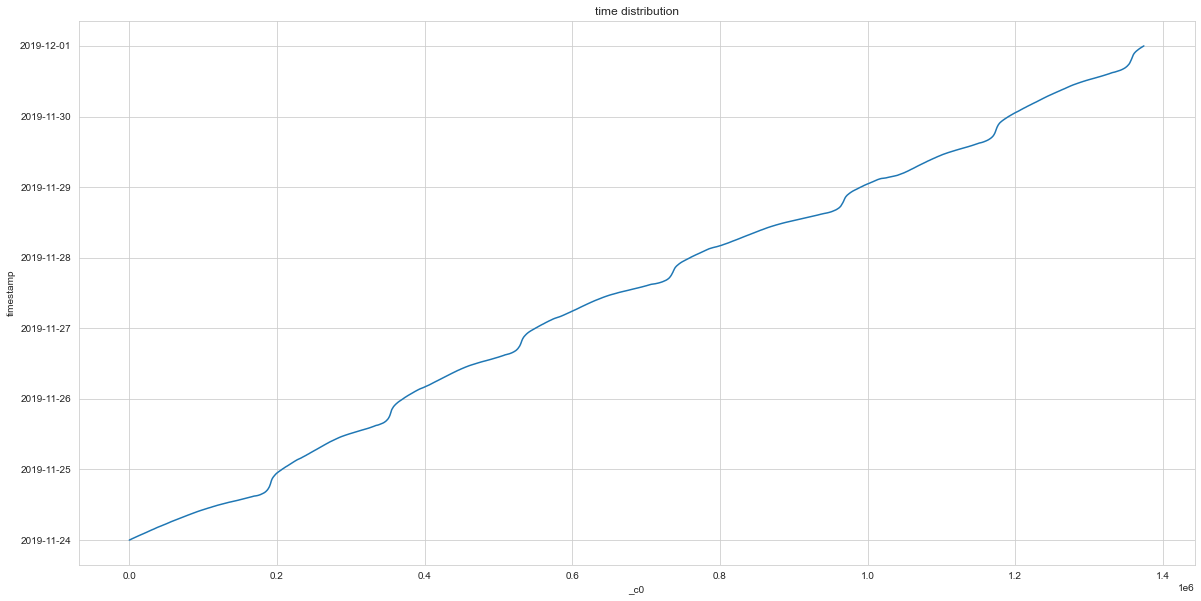

In [19]:
plt.figure(figsize=(20,10))
plt.title("time distribution")
sns.lineplot(data=pd.to_datetime(dataset_random_all.data.timestamp))
plt.show()

In [20]:
dataset_random_all.data.head(100)

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
_c0,,,,,,,,,,,,,,,,,,,,,
0,2019-11-24 00:00:00.007000+00:00,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
1,2019-11-24 00:00:00.015000+00:00,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
2,2019-11-24 00:00:00.016000+00:00,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
3,2019-11-24 00:00:01.856000+00:00,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884
4,2019-11-24 00:00:01.857000+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2019-11-24 00:00:50.943000+00:00,27,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,2d03db5543b14483e52d761760686b64,9b2d331c329ceb74d3dcfb48d8798c78,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,773094114299
96,2019-11-24 00:00:53.961000+00:00,68,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,670014898176
97,2019-11-24 00:00:53.965000+00:00,14,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,670014898176


In [21]:
# dataset_bts_all.data.head(1000)

In [23]:
bandit_feedback_dataset_random_all = dataset_random_all.obtain_batch_bandit_feedback()

In [26]:
bandit_feedback_dataset_random_all.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

## Loading Raw dataset and sample slate_id

In [3]:
raw_preprocessed_random_all_data_path = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed/random/all/all.csv')

dataset_raw_preprocessed_random_all = pd.read_csv(raw_preprocessed_random_all_data_path, index_col=0)

In [6]:
dataset_raw_preprocessed_random_all.shape

(1208895, 90)

In [7]:
dataset_raw_preprocessed_random_all.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
_c0,,,,,,,,,,,,,,,,,,,,,
0,2019-11-24T00:00:00.007Z,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
1,2019-11-24T00:00:00.015Z,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
2,2019-11-24T00:00:00.016Z,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,549755814919
3,2019-11-24T00:00:01.856Z,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884
4,2019-11-24T00:00:01.857Z,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,738734375884


In [8]:
dataset_raw_preprocessed_random_all.dtypes

timestamp                 object
item_id                    int64
position                   int64
click                      int64
propensity_score         float64
                          ...   
user-item_affinity_76    float64
user-item_affinity_77    float64
user-item_affinity_78    float64
user-item_affinity_79    float64
slate_id                   int64
Length: 90, dtype: object

In [82]:
sample_slate_id_array = dataset_raw_preprocessed_random_all.slate_id.sample(10100).unique()

sample_slate_id_array

array([1520418423528, 1314259994306,  541165879625, ...,  575525619527,
        214748366859, 1151051236815])

In [86]:
dataset_slate_sample_random_all = dataset_raw_preprocessed_random_all[dataset_raw_preprocessed_random_all.slate_id.apply(lambda x: x in sample_slate_id_array)]

In [87]:
dataset_slate_sample_random_all.shape

(30006, 90)

In [88]:
dataset_slate_sample_random_all.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79,slate_id
_c0,,,,,,,,,,,,,,,,,,,,,
9,2019-11-24T00:00:03.956Z,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
10,2019-11-24T00:00:03.956Z,48,3,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
11,2019-11-24T00:00:03.956Z,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,719dab53a7560218a9d1f96b25d6fa32,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,970662609927
120,2019-11-24T00:01:03.126Z,28,1,0,0.0125,cef3390ed299c09874189c387777674a,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,884763263977
121,2019-11-24T00:01:03.126Z,49,2,0,0.0125,cef3390ed299c09874189c387777674a,03a5648a76832f83c859d46bc06cb64a,c2e4f76cdbabecd33b8c762aeef386b3,9bde591ffaab8d54c457448e4dca6f53,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,884763263977


In [90]:
slate_sample_write_path = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed/sample/random/all/all.csv')


dataset_slate_sample_random_all.to_csv(path_or_buf=slate_sample_write_path)